In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
tf.enable_eager_execution()
import importlib
import os

from matplotlib import pyplot as plt
%matplotlib notebook

from transliteration import data, train, model_one, script, decode, evaluate

In [2]:
importlib.reload(data)
batch_size = 50
muse_train_dataset = data.make_dataset('../data/tfrecord/muse_train.tfrecord',
                                       from_script='en',
                                       to_script='ja',
                                       batch_size=batch_size)
muse_valid_dataset = data.make_dataset('../data/tfrecord/muse_valid.tfrecord',
                                       from_script='en',
                                       to_script='ja',
                                       batch_size=batch_size)
muse_test_dataset = data.make_dataset('../data/tfrecord/muse_test.tfrecord',
                                      from_script='en',
                                      to_script='ja',
                                      batch_size=batch_size)
cmu_train_dataset = data.make_dataset('../data/tfrecord/cmu_train.tfrecord',
                                  from_script='en',
                                  to_script='cmu',
                                  batch_size=batch_size)
cmu_valid_dataset = data.make_dataset('../data/tfrecord/cmu_valid.tfrecord',
                                  from_script='en',
                                  to_script='cmu',
                                  batch_size=batch_size)
cmu_test_dataset = data.make_dataset('../data/tfrecord/cmu_test.tfrecord',
                                 from_script='en',
                                 to_script='cmu',
                                 batch_size=batch_size)
eob_train_dataset = data.make_dataset('../data/tfrecord/eob_train.tfrecord',
                                       from_script='en',
                                       to_script='ja',
                                       batch_size=batch_size)
eob_valid_dataset = data.make_dataset('../data/tfrecord/eob_valid.tfrecord',
                                       from_script='en',
                                       to_script='ja',
                                       batch_size=batch_size)
eob_test_dataset = data.make_dataset('../data/tfrecord/eob_test.tfrecord',
                                      from_script='en',
                                      to_script='ja',
                                      batch_size=batch_size)

In [3]:
importlib.reload(model_one)
optimizer = tf.train.AdamOptimizer()


def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred)
    return tf.reduce_mean(loss_ * mask)

cmu_encoder_config = model_one.Config(lstm_size=240,
                                      embedding_size=30,
                                      attention_size=None,
                                      vocab_size=script.SCRIPTS['en'].vocab_size)
ja_encoder_config = model_one.Config(lstm_size=120,
                                      embedding_size=30,
                                      attention_size=None,
                                      vocab_size=script.SCRIPTS['en'].vocab_size)
ja_decoder_config = model_one.Config(lstm_size=80,
                                     embedding_size=30,
                                     attention_size=60,
                                     # attention='monotonic_bahdanau',
                                     vocab_size=script.SCRIPTS['ja'].vocab_size)
cmu_decoder_config = model_one.Config(lstm_size=240,
                                  embedding_size=30,
                                  attention_size=120,
                                  # attention='monotonic_bahdanau',
                                  vocab_size=script.SCRIPTS['cmu'].vocab_size)
cmu_encoder = model_one.Encoder(cmu_encoder_config)
ja_encoder = model_one.CombinedEncoder(ja_encoder_config, cmu_encoder)
ja_decoder = model_one.Decoder(ja_decoder_config)
cmu_decoder = model_one.Decoder(cmu_decoder_config)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 cmu_encoder=cmu_encoder,
                                 ja_encoder=ja_encoder,
                                 ja_decoder=ja_decoder,
                                 cmu_decoder=cmu_decoder)

In [4]:
cmu_best_val_loss = None
cmu_checkpoint = None
for e in range(5):
    loss = train.run_one_epoch(cmu_train_dataset,
                               True,
                               from_script='en',
                               to_script='cmu',
                               encoder=cmu_encoder,
                               decoder=cmu_decoder,
                               optimizer=optimizer,
                               loss_function=loss_function)
    valid_loss = train.run_one_epoch(cmu_valid_dataset,
                                     False,
                                     from_script='en',
                                     to_script='cmu',
                                     encoder=cmu_encoder,
                                     decoder=cmu_decoder,
                                     loss_function=loss_function)
    if cmu_best_val_loss is None or valid_loss < cmu_best_val_loss:
        cmu_best_val_loss = valid_loss
        cmu_checkpoint = checkpoint.save(file_prefix=checkpoint_prefix)
    print("Epoch {}: Train Loss {:.3f}, Valid Loss {:.3f}".format(e, loss, valid_loss))
    print(decode.transliterate(input_strs=['derick'],
                               from_script='en',
                               to_script='cmu',
                               encoder=cmu_encoder,
                               decoder=cmu_decoder,
                               k_best=2,
                               decoding_method=decode.beam_search_decode))

Instructions for updating:
Colocations handled automatically by placer.


Epoch 0: Train Loss 7.526, Valid Loss 3.146
([['D EH1 R IH0 K K', 'D ER0 IH1 K K K K']], array([[-3.14659954, -3.24997213]]))


Epoch 1: Train Loss 2.697, Valid Loss 2.544
([['D EH1 R IH0 K K', 'D EH1 R IH0 K K IH2 K']], array([[-2.34462175, -3.47583164]]))


Epoch 2: Train Loss 2.225, Valid Loss 2.221
([['D ER0 IH1 K K K', 'D ER0 IH1 K K IH0 K']], array([[-3.49892964, -3.92489112]]))


Epoch 3: Train Loss 1.970, Valid Loss 2.118
([['D ER0 IH1 K K IH0 K', 'D EH1 R IH0 K IH0 K']], array([[-2.86841952, -2.87745389]]))


Epoch 4: Train Loss 1.785, Valid Loss 2.063
([['D EH1 R IH0 K K AA2 K', 'D EH1 R IH0 K K EH2 K K']], array([[-1.92049986, -2.32618642]]))


In [5]:
checkpoint.restore(cmu_checkpoint)
print(train.run_one_epoch(cmu_valid_dataset,
                          False,
                          from_script='en',
                          to_script='cmu',
                          encoder=cmu_encoder,
                          decoder=cmu_decoder,
                          loss_function=loss_function))
for layer in cmu_encoder.layers:
    layer.trainable = False

tf.Tensor(2.064941, shape=(), dtype=float32)


In [6]:
best_val_loss = None
ja_checkpoint = None
for e in range(15):
    loss = train.run_one_epoch(eob_train_dataset,
                               True,
                               from_script='en',
                               to_script='ja',
                               encoder=ja_encoder,
                               decoder=ja_decoder,
                               optimizer=optimizer,
                               loss_function=loss_function)
    valid_loss = train.run_one_epoch(eob_valid_dataset,
                                     False,
                                     from_script='en',
                                     to_script='ja',
                                     encoder=ja_encoder,
                                     decoder=ja_decoder,
                                     loss_function=loss_function)
    if best_val_loss is None or valid_loss < best_val_loss:
        best_val_loss = valid_loss
        ja_checkpoint = checkpoint.save(file_prefix=checkpoint_prefix)
    print("Epoch {}: Train Loss {:.3f}, Valid Loss {:.3f}".format(e, loss, valid_loss))
    print(decode.transliterate(input_strs=['derick'],
                               from_script='en',
                               to_script='ja',
                               encoder=ja_encoder,
                               decoder=ja_decoder,
                               k_best=2,
                               decoding_method=decode.beam_search_decode))

Epoch 0: Train Loss 14.721, Valid Loss 8.662


([['デリッククキカクク', 'デリッククキカクキカクク']], array([[ -8.27814012, -12.20292812]]))


Epoch 1: Train Loss 7.167, Valid Loss 6.637


([['デリックククキクククキクククキクククキ', 'デリッククキクククキクククキクククキク']], array([[-11.52476271, -11.6754705 ]]))


Epoch 2: Train Loss 5.513, Valid Loss 5.533


([['デリッククキックククキクククキクククキ', 'デリックククキクククキクククキクククキ']], array([[-12.73775936, -12.80212651]]))


Epoch 3: Train Loss 4.638, Valid Loss 5.332


([['デリ', 'デリッククキッククククキクククキククク']], array([[ -2.36959624, -10.38566782]]))


Epoch 4: Train Loss 4.066, Valid Loss 5.074


([['デリックククキクカクキクカクキクカクキ', 'デリックククキクカクキクカクキカクキク']], array([[-12.76267826, -12.98927641]]))


Epoch 5: Train Loss 3.630, Valid Loss 5.007


([['デリックカクキクカクキクカクキクカクキ', 'デリックカクキクカクキクケクキクカクキ']], array([[-12.44827367, -12.49847938]]))


Epoch 6: Train Loss 3.246, Valid Loss 5.000


([['デリックククキカクククククククククキク', 'デリッククククキカクククククククククク']], array([[-11.46368343, -11.5627499 ]]))


Epoch 7: Train Loss 2.913, Valid Loss 4.932


([['デリックカク', 'デリックククキクククキクククキクククキ']], array([[ -3.1713637 , -11.73047956]]))


Epoch 8: Train Loss 2.635, Valid Loss 5.061


([['デリックカキックカクキクカクキクカクキ', 'デリックカキックカクキクケクキクカクキ']], array([[-11.90853087, -11.9355402 ]]))


Epoch 9: Train Loss 2.404, Valid Loss 5.097


([['デリッククククキクカクキカククカキカク', 'デリッククククキクカクキカクカキカクク']], array([[-10.99771493, -11.11367338]]))


Epoch 10: Train Loss 2.194, Valid Loss 5.102


([['デリックククククククククククククククク', 'デリックククククククククククククククキ']], array([[-7.22340877, -7.77812488]]))


Epoch 11: Train Loss 2.004, Valid Loss 5.334


([['デリックカックキカックキカックキカック', 'デリックカックキカックキカックカキカク']], array([[-9.08701817, -9.68015648]]))


Epoch 12: Train Loss 1.791, Valid Loss 5.307


([['デリックカックカキクカクキクカクキクカ', 'デリックカックカキクカクキクカクキカキ']], array([[-8.97151248, -9.28529684]]))


Epoch 13: Train Loss 1.643, Valid Loss 5.495


([['デリックカックキカクキカックカキクカク', 'デリックカックキカクキカックキカックク']], array([[-7.66936729, -7.8309812 ]]))


Epoch 14: Train Loss 1.534, Valid Loss 5.589


([['デリックククククククククククククククク', 'デリッククククキククククククククククク']], array([[-8.49770908, -8.549552  ]]))


In [7]:
checkpoint.restore(ja_checkpoint).assert_consumed()
train.run_one_epoch(eob_valid_dataset,
                    False,
                    from_script='en',
                    to_script='ja',
                    encoder=ja_encoder,
                    decoder=ja_decoder,
                    loss_function=loss_function)

<tf.Tensor: id=293276346, shape=(), dtype=float32, numpy=4.9871974>

In [8]:
decode.transliterate(input_strs=['william'],
                     from_script='en',
                     to_script='ja',
                     encoder=ja_encoder,
                     decoder=ja_decoder,
                     k_best=2,
                     num_beams=40,
                     decoding_method=decode.beam_search_decode)

([['ウイリアム', 'ウイリアムマム']], array([[-2.13591648, -2.84364242]]))

In [9]:
valid_df = pd.read_csv('../data/split/eob_pairs_valid.csv',
                       keep_default_na=False)

In [13]:
importlib.reload(decode)
tr = decode.transliterate(input_strs=valid_df['en'].values,
                     from_script='en',
                     to_script='ja',
                     encoder=ja_encoder,
                     decoder=ja_decoder,
                     k_best=20,
                     num_beams=40,
                     decoding_method=decode.beam_search_decode)

In [14]:
evaluate.top_k_accuracy(valid_df['ja'].values, tr, k=1)

0.39978094194961666

In [15]:
ks = list(range(1, 21))
accuracies = [evaluate.top_k_accuracy(valid_df['ja'].values, tr, k=k) for k in ks]

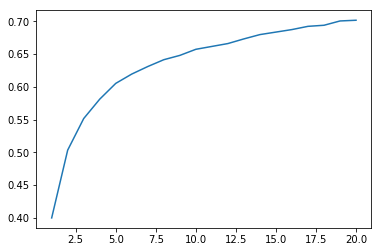

In [16]:
plt.plot(ks, accuracies)

In [29]:
importlib.reload(evaluate)
evaluate.mrr(valid_df['ja'].values,
             tr,
             k=20)

0.5288660969831264